# Classification using ViT and Hugging face

## GPU information
`!nvidia-smi` is a command line utility that is used to manage and monitor NVIDIA GPU devices. It is based on top of the NVIDIA Management Library (NVML) and allows administrators to query GPU device state and modify GPU device state with the appropriate privileges. It is targeted at the Tesla TM, GRID TM, Quadro TM, and Titan X product, though limited support is also available on other NVIDIA GPUs. `nvidia-smi` ships with NVIDIA GPU display drivers on Linux, and with 64bit Windows Server 2008 R2 and Windows 7. `nvidia-smi` can report query information as XML or human-readable plain text to either standard output or a file ¹.

For more see:

1. System Management Interface SMI | NVIDIA Developer. https://developer.nvidia.com/nvidia-system-management-interface.
2. How do I run nvidia-smi on Windows? - Stack Overflow. https://stackoverflow.com/questions/57100015/how-do-i-run-nvidia-smi-on-windows.
3. Useful nvidia-smi Queries | NVIDIA. https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries.

In [2]:
# provide GPU information
!nvidia-smi

Sun Aug 20 16:04:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.00       Driver Version: 517.00       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8    13W /  N/A |      0MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load Data & Libraries

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from transformers import ViTFeatureExtractor, ViTForImageClassification, AutoFeatureExtractor, ResNetForImageClassification
from transformers import TrainingArguments, Trainer
from datasets import load_metric, DatasetDict, Dataset, load_dataset

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import wandb
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score

import warnings
warnings.filterwarnings("ignore")

c:\Users\sebas\Documents\projet\transformers_hugging_face\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# login to wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sebastien-s. Use `wandb login --relogin` to force relogin


True

In [5]:
# counting the number of file in the data folder
import os

def count_files(folder_path):
    file_counts = {}
    for root, dirs, files in os.walk(folder_path):
        count = len(files)
        file_counts[root] = count
    return file_counts

folder_path = '../data/shoe_boot_sandal/Shoe vs Sandal vs Boot Dataset/'
file_counts = count_files(folder_path)
for folder, count in file_counts.items():
    print(f"Number of files in {folder}: {count}")


Number of files in ../data/shoe_boot_sandal/Shoe vs Sandal vs Boot Dataset/: 0
Number of files in ../data/shoe_boot_sandal/Shoe vs Sandal vs Boot Dataset/Boot: 5000
Number of files in ../data/shoe_boot_sandal/Shoe vs Sandal vs Boot Dataset/Sandal: 5000
Number of files in ../data/shoe_boot_sandal/Shoe vs Sandal vs Boot Dataset/Shoe: 5000


In [6]:
# define the dataset
datasets = load_dataset('imagefolder', data_dir='../data/shoe_boot_sandal/Shoe vs Sandal vs Boot Dataset/')
datasets

Resolving data files: 100%|██████████| 15000/15000 [00:00<00:00, 18498.25it/s]


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 15000
    })
})

In [7]:
# split the dataset
datasets = datasets['train'].train_test_split(test_size=.2, seed=42)
datasets

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3000
    })
})

In [8]:
# split the train dataset into train and validation
datasets_split = datasets['train'].train_test_split(test_size=.2, seed=42)

# defining the train datasets
datasets['train'] = datasets_split['train']

# defining the validation datasets
datasets['validation'] = datasets_split['test']

datasets

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9600
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2400
    })
})

In [9]:
# get the labels
labels = datasets['train'].features['label'].names
labels

['Boot', 'Sandal', 'Shoe']

(6, 2)


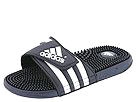

In [10]:
# select the first 6 samples
print(datasets['train'].select(range(6)).shape)
datasets['train'].select(range(6))[5]['image']

In [11]:
datasets['train'].features['label']

ClassLabel(names=['Boot', 'Sandal', 'Shoe'], id=None)

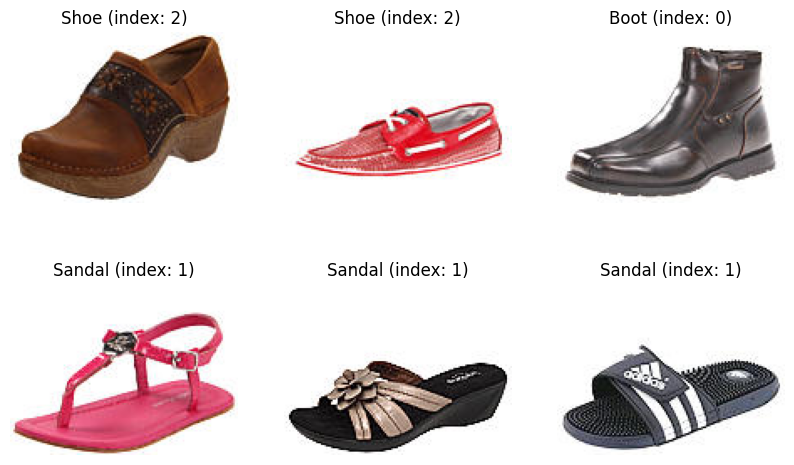

In [86]:
# plot samples
def plot_samples(samples, labels):
    # the pointer variable is used to keep track of the current index of the samples
    pointer = 0

    fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
    for i in range(2):
        for j in range(3):
            ax[i,j].imshow(samples[pointer]['image'])
            ax[i,j].set_title(f"{labels[samples[pointer]['label']]} (index: {samples[pointer]['label']})")
            ax[i,j].axis('off')
            pointer+=1

    plt.show()

# Call the function
plot_samples(datasets['train'].select(range(6)), labels)


## Vision Transformers (ViT)

In [13]:
# model name
model_ckpt = 'google/vit-base-patch16-224-in21k'

# selecting GPU device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Feature extraction

[inspiration](https://medium.com/data-folks-indonesia/exploring-visual-transformers-vit-with-huggingface-8cdda82920a0)

> Next, as we already know, we need to transform our images into fixed-size patches and flatten it. We also need to add positional encoding and the classification token. Here we will use 🤗 Huggingface Feature Extractor module which do all mechanism for us!
> 
> This Feature Extractor is just like Tokenizer in NLP. We will examine the outputs of processed image. Here we will use pretrained ViT with patch_size=16 and pretrained on ImageNet21K dataset with resolution 224x224.

In [14]:
# define the feature extractor
extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)
extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

We can see above the configuration of the feature extractor.

To process an image, simply pass it to the feature extractor's call function. This will return a dict containing pixel values, which is the numeric representation to be passed to the model.

You get a NumPy array by default, but if you add the `return_tensors='pt'` argument, you'll get back torch tensors instead. (according to https://huggingface.co/blog/fine-tune-vit)

In [15]:
# defining a sample
samples = datasets['train'].select(range(6))

# applying the feature extractor on an image
extractor(samples[0]['image'], return_tensors='pt')
# there are a lot of ones bcs the background of imgs are white, so its normal

{'pixel_values': tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])}

#### Processing the Dataset

Now that you know how to read images and transform them into inputs, let's write a function that will put those two things together to process a batch from the dataset.

In [16]:
# preprocessing function
def batch_transform(examples):
    """
    Takes a batch of images and turn them into pixel values
    Outputs PyTorch tensors
    """
    # take a list of PIL images and turn into pixel values
    inputs = extractor([x for x in examples['image']], return_tensors='pt')

    # add the labels in
    inputs['label'] = examples['label']
    
    return inputs

# apply the preprocessing
transformed_data = datasets.with_transform(batch_transform)
transformed_data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9600
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2400
    })
})

#### Define our data collator (from [this](https://huggingface.co/blog/fine-tune-vit))

Batches are coming in as lists of dicts, so you can just unpack + stack those into batch tensors.

Since the collate_fn will return a batch dict, you can **unpack the inputs to the model later. ✨

In [17]:
# data collator
def collate_fn(examples):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in examples]),
        'labels': torch.tensor([x['label'] for x in examples])
    }

# metrics
metric = load_metric('accuracy')
def compute_metrics(p):
    labels = p.label_ids
    preds = p.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'f1': f1
    }
#     return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

### ViT Zero-Shot

In [18]:
# define the model
# for information labels = datasets['train'].features['label'].names (see above)
model = ViTForImageClassification.from_pretrained(model_ckpt,
                                                 num_labels=len(labels),
                                                 id2label={str(i): c for i, c in enumerate(labels)},
                                                 label2id={c: str(i) for i, c in enumerate(labels)})
model = model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# define the data loader
zero_loader = DataLoader(transformed_data['test'], batch_size=16)

def get_predictions(model, data_loader, labels):
    predictions = []

    for batch in tqdm(data_loader):
        with torch.no_grad():        
            logits = model(batch['pixel_values'].to(device)).logits
            pred = logits.argmax(-1).cpu().detach().tolist()
            predictions += [labels[i] for i in pred]

    return predictions

# Usage
zero_pred = get_predictions(model, zero_loader, labels)


100%|██████████| 188/188 [01:00<00:00,  3.12it/s]


In [20]:
zero_pred[:5]

['Boot', 'Boot', 'Boot', 'Boot', 'Shoe']

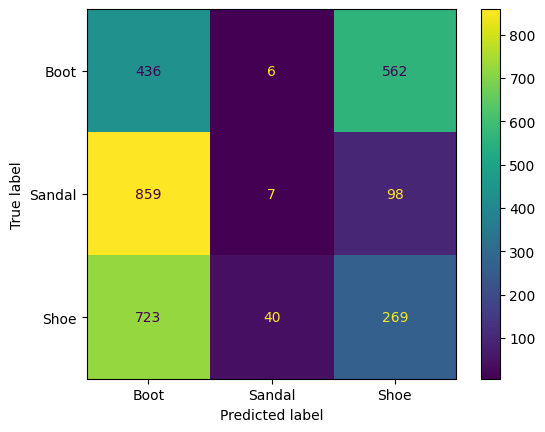

In [21]:
# definie the true target list
zero_true = [labels[i] for i in datasets['test']['label']]

cm = confusion_matrix(zero_true, zero_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
plt.show()

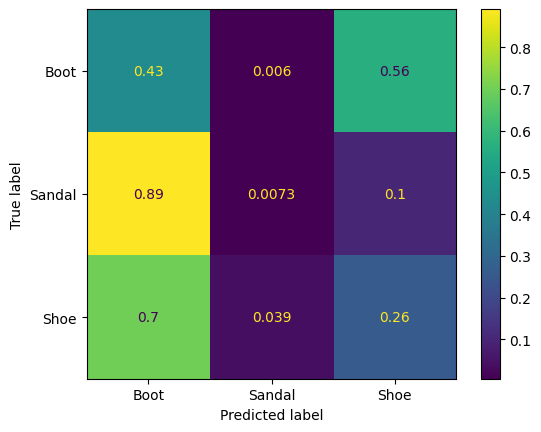

In [22]:
# V2 : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
ConfusionMatrixDisplay.from_predictions(zero_true, zero_pred, normalize='true')
plt.show()

The confusion matrix shows the distribution of the true and predicted labels for a classification problem¹[1]. The rows represent the actual labels, while the columns represent the predicted labels. The diagonal elements show the number of correct predictions, while the off-diagonal elements show the number of incorrect predictions.

The confusion matrix can be used to calculate various metrics such as accuracy, precision, recall, sensitivity, specificity, and F1 score. These metrics can be used to evaluate how well a machine learning model is performing on a given dataset.

In this case, the confusion matrix has three classes: Boot, Sandal, and Shoe. The values in the matrix are normalized by the total number of samples, so they range from 0 to 1. The darker colors indicate lower values, while the lighter colors indicate higher values.

- The highest value in the matrix is 0.59, which is located in the top right corner of the matrix. This means that 59% of the samples that were actually Boot were misclassified as Shoes by the model. This is a poor result, as it indicates that the model has a low accuracy and specificity for the Boot class.

- The lowest value in the matrix is 0.07, which is located in the mid left of the matrix. This means that only 7% of the samples that were actually Sandal were misclassified as Boots by the model. This is seems good result compare to the diagonal value of 48%.

To improve the performance of the model, I would try to analyze the sources of error and confusion in the predictions. I would also try to use different features, algorithms, or hyperparameters to optimize the model. I would also try to collect more data or use data augmentation techniques to increase the diversity and quality of the dataset.


In [23]:
print(f'ViT zero-shot Acc: {accuracy_score(zero_true, zero_pred):.3f}')
print(f'ViT zero-shot F1: {f1_score(zero_true, zero_pred, average="weighted"):.3f}')

ViT zero-shot Acc: 0.237
ViT zero-shot F1: 0.195


### Fine-tuning of the ViT

In [24]:
# defining config parameters
vit_config = dict(learning_rate = 1e-5,
                  architecture = 'ViT',
                  dataset_id = 'shoe-sandal-boots',
                  infra='local')

# initialize wandb project
run = wandb.init(project='shoe-vs-sandals-vs-boots',
                notes='SMLT course project',
                tags=['comparison', 'ViT', 'ResNet'],                 
                config=vit_config,
                name='hf-ViT-base-16-224')

In [25]:
# train props
batch_size = 16
logging_steps = len(transformed_data['train']) // batch_size

training_args = TrainingArguments(output_dir='./local/working/',
                                 report_to='wandb',
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 evaluation_strategy='epoch',
                                 save_strategy='epoch',
                                 num_train_epochs=3,
                                 fp16=True if torch.cuda.is_available() else False,
                                 logging_steps=logging_steps,
                                 learning_rate=1e-5,
                                 save_total_limit=2,
                                 remove_unused_columns=False,
                                 push_to_hub=False,
                                 load_best_model_at_end=True)

trainer = Trainer(model=model,
                 args=training_args,
                 data_collator=collate_fn,
                 compute_metrics=compute_metrics,
                 train_dataset=transformed_data['train'],
                 eval_dataset=transformed_data['validation'],
                 tokenizer=extractor) # require accelerate module

train_result = trainer.train()

 33%|███▎      | 600/1800 [04:45<09:47,  2.04it/s]

{'loss': 0.2138, 'learning_rate': 6.672222222222223e-06, 'epoch': 1.0}


                                                  
 33%|███▎      | 600/1800 [05:43<09:47,  2.04it/s]

{'eval_loss': 0.06109067425131798, 'eval_accuracy': 0.99125, 'eval_f1': 0.9912501644676532, 'eval_runtime': 57.6895, 'eval_samples_per_second': 41.602, 'eval_steps_per_second': 2.6, 'epoch': 1.0}


 67%|██████▋   | 1200/1800 [08:17<02:12,  4.52it/s] 

{'loss': 0.0395, 'learning_rate': 3.3388888888888893e-06, 'epoch': 2.0}


                                                   
 67%|██████▋   | 1200/1800 [08:36<02:12,  4.52it/s]

{'eval_loss': 0.046824969351291656, 'eval_accuracy': 0.99125, 'eval_f1': 0.9912417981570745, 'eval_runtime': 18.877, 'eval_samples_per_second': 127.139, 'eval_steps_per_second': 7.946, 'epoch': 2.0}


100%|██████████| 1800/1800 [10:59<00:00,  4.65it/s]  

{'loss': 0.024, 'learning_rate': 1.1111111111111112e-08, 'epoch': 3.0}


                                                   
100%|██████████| 1800/1800 [11:18<00:00,  4.65it/s]

{'eval_loss': 0.04075149446725845, 'eval_accuracy': 0.9933333333333333, 'eval_f1': 0.9933288719594956, 'eval_runtime': 19.0233, 'eval_samples_per_second': 126.161, 'eval_steps_per_second': 7.885, 'epoch': 3.0}


100%|██████████| 1800/1800 [11:20<00:00,  2.65it/s]

{'train_runtime': 680.3214, 'train_samples_per_second': 42.333, 'train_steps_per_second': 2.646, 'train_loss': 0.09246063179439969, 'epoch': 3.0}


In [26]:
# evaluate
trainer.evaluate(transformed_data['validation'])

100%|██████████| 150/150 [00:17<00:00,  8.35it/s]


{'eval_loss': 0.04075149446725845,
 'eval_accuracy': 0.9933333333333333,
 'eval_f1': 0.9933288719594956,
 'eval_runtime': 18.452,
 'eval_samples_per_second': 130.067,
 'eval_steps_per_second': 8.129,
 'epoch': 3.0}

In [27]:
# predictions
predictions = trainer.predict(transformed_data['test'])
predictions.metrics

100%|██████████| 188/188 [00:28<00:00,  6.51it/s]


{'test_loss': 0.040758416056632996,
 'test_accuracy': 0.994,
 'test_f1': 0.9939998822582984,
 'test_runtime': 29.3648,
 'test_samples_per_second': 102.163,
 'test_steps_per_second': 6.402}

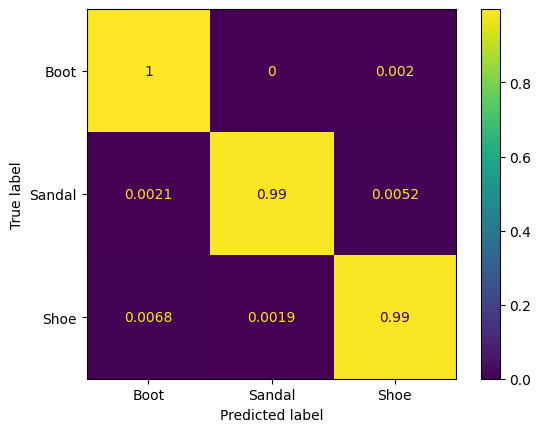

In [116]:
# convert the predictions to labels
vit_pred = [labels[idx] for idx in predictions.predictions.argmax(axis=1).tolist()]

# plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(zero_true, vit_pred, normalize='true')
plt.show()

In [28]:
# finish the experiment
run.finish()

eval/accuracy,▁▁██
eval/f1,▁▁██
eval/loss,█▃▁▁
eval/runtime,█▁▁▁
eval/samples_per_second,▁███
eval/steps_per_second,▁███
train/epoch,▁▁▅▅████
train/global_step,▁▁▅▅████
train/learning_rate,█▄▁
train/loss,█▂▁
train/total_flos,▁


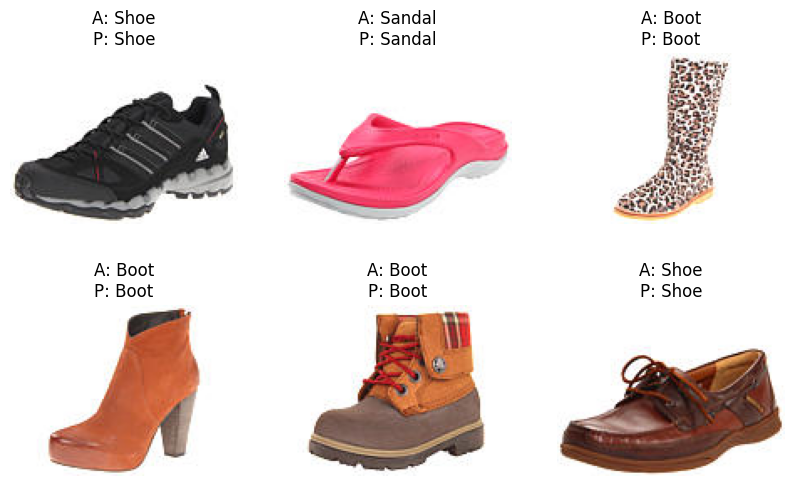

In [112]:
def plot_samples(samples, labels, predictions=None):
    pointer = 0

    fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
    for i in range(2):
        for j in range(3):
            ax[i,j].imshow(samples[pointer]['image'])
            if predictions:
                ax[i,j].set_title(f"A: {labels[samples[pointer]['label']]}\nP: {labels[predictions.label_ids[pointer]]}")
            else:
                ax[i,j].set_title(f"{labels[samples[pointer]['label']]}")
            ax[i,j].axis('off')
            pointer+=1

    plt.show()

# Call the function
plot_samples(datasets['test'].select(range(6)), labels, predictions)


## RESNET50
### RESNET Zero Shot

In [74]:
# defining the model
resnet50_ckpt = 'microsoft/resnet-50'

# define the feature extractor
resnet_extractor = AutoFeatureExtractor.from_pretrained(resnet50_ckpt)

# define the model
resnet_model = ResNetForImageClassification.from_pretrained(resnet50_ckpt,
                                                    num_labels=len(labels),
                                                    id2label={str(i): c for i, c in enumerate(labels)},
                                                    label2id={c: str(i) for i, c in enumerate(labels)},
                                                    ignore_mismatched_sizes=True)

resnet_model = resnet_model.to(device)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([3, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
transformed_data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9600
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2400
    })
})

In [75]:
# define the prediction function
def get_predictions(data_loader, model, device):
    predictions = []
    for batch in tqdm(data_loader):
        with torch.no_grad():
            logits = model(batch['pixel_values'].to(device)).logits
            pred = logits.argmax(-1).cpu().detach().tolist()
            predictions += [labels[i] for i in pred]
    return predictions

# define the data loader
zero_loader = DataLoader(transformed_data['test'], batch_size=16)

# get the predictions
resnet_zero_pred = get_predictions(zero_loader, resnet_model, device)

100%|██████████| 188/188 [00:24<00:00,  7.55it/s]


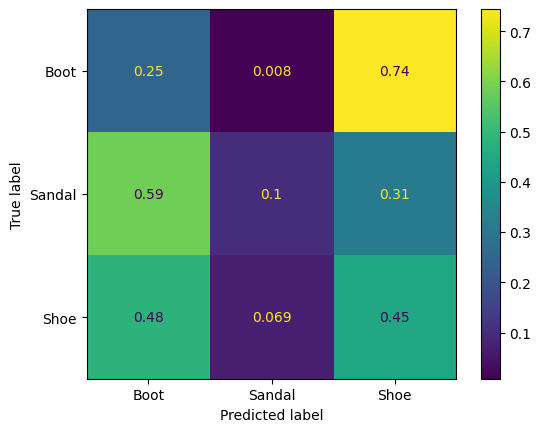

In [76]:
# plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(zero_true, resnet_zero_pred, normalize='true')
plt.show()

In [77]:
# show the results
print(f'ResNet50 zero-shot Acc: {accuracy_score(zero_true, zero_pred):.3f}')
print(f'ResNet50 zero-shot F1: {f1_score(zero_true, zero_pred, average="weighted"):.3f}')

ResNet50 zero-shot Acc: 0.237
ResNet50 zero-shot F1: 0.195


### RESNET Fine tuning

In [78]:
resnet50_config = dict(learning_rate = 1e-5,
                  architecture = 'ResNet50',
                  dataset_id = 'shoe-sandal-boots',
                  infra='local')

run = wandb.init(project='shoe-vs-sandals-vs-boots',
                notes='Test project',
                tags=['comparison', 'ViT', 'ResNet'],                 
                config=resnet50_config,
                name='hf-ResNet-50')

In [79]:
# define the training arguments
resnet50_args = TrainingArguments(output_dir=f"./{resnet50_config['infra']}/working/",
                                 report_to='wandb',
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 evaluation_strategy='epoch',
                                 save_strategy='epoch',
                                 num_train_epochs=3,
                                 fp16=True if torch.cuda.is_available() else False,
                                 logging_steps=logging_steps,
                                 learning_rate=resnet50_config['learning_rate'],
                                 save_total_limit=2,
                                 remove_unused_columns=False,
                                 push_to_hub=False,
                                 load_best_model_at_end=True,)
# define the trainer
resnet50_trainer = Trainer(model=resnet_model,
                 args=resnet50_args,
                 data_collator=collate_fn,
                 compute_metrics=compute_metrics,
                 train_dataset=transformed_data['train'],
                 eval_dataset=transformed_data['validation'],
                 tokenizer=resnet_extractor)

# train the model
resnet50_trainer.train()

 33%|███▎      | 600/1800 [02:08<07:09,  2.79it/s]

{'loss': 1.0496, 'learning_rate': 6.683333333333334e-06, 'epoch': 1.0}



 33%|███▎      | 600/1800 [03:25<07:09,  2.79it/s]

{'eval_loss': 0.979946494102478, 'eval_accuracy': 0.7283333333333334, 'eval_f1': 0.7130788678629282, 'eval_runtime': 77.335, 'eval_samples_per_second': 31.034, 'eval_steps_per_second': 1.94, 'epoch': 1.0}


 67%|██████▋   | 1200/1800 [07:25<03:03,  3.27it/s] 

{'loss': 0.9134, 'learning_rate': 3.3555555555555557e-06, 'epoch': 2.0}



 67%|██████▋   | 1200/1800 [07:52<03:03,  3.27it/s]

{'eval_loss': 0.8395932912826538, 'eval_accuracy': 0.8041666666666667, 'eval_f1': 0.7996423244683395, 'eval_runtime': 27.2026, 'eval_samples_per_second': 88.227, 'eval_steps_per_second': 5.514, 'epoch': 2.0}


100%|██████████| 1800/1800 [11:31<00:00,  2.53it/s]  

{'loss': 0.8173, 'learning_rate': 2.2222222222222224e-08, 'epoch': 3.0}



100%|██████████| 1800/1800 [12:09<00:00,  2.53it/s]

{'eval_loss': 0.7822985053062439, 'eval_accuracy': 0.8125, 'eval_f1': 0.8073099304613964, 'eval_runtime': 37.7899, 'eval_samples_per_second': 63.509, 'eval_steps_per_second': 3.969, 'epoch': 3.0}


100%|██████████| 1800/1800 [12:10<00:00,  2.46it/s]

{'train_runtime': 730.2377, 'train_samples_per_second': 39.439, 'train_steps_per_second': 2.465, 'train_loss': 0.926752454969618, 'epoch': 3.0}


TrainOutput(global_step=1800, training_loss=0.926752454969618, metrics={'train_runtime': 730.2377, 'train_samples_per_second': 39.439, 'train_steps_per_second': 2.465, 'train_loss': 0.926752454969618, 'epoch': 3.0})

In [102]:
# model info
resnet50_trainer.model.config

ResNetConfig {
  "_name_or_path": "microsoft/resnet-50",
  "architectures": [
    "ResNetForImageClassification"
  ],
  "depths": [
    3,
    4,
    6,
    3
  ],
  "downsample_in_first_stage": false,
  "embedding_size": 64,
  "hidden_act": "relu",
  "hidden_sizes": [
    256,
    512,
    1024,
    2048
  ],
  "id2label": {
    "0": "Boot",
    "1": "Sandal",
    "2": "Shoe"
  },
  "label2id": {
    "Boot": "0",
    "Sandal": "1",
    "Shoe": "2"
  },
  "layer_type": "bottleneck",
  "model_type": "resnet",
  "num_channels": 3,
  "out_features": [
    "stage4"
  ],
  "out_indices": [
    4
  ],
  "problem_type": "single_label_classification",
  "stage_names": [
    "stem",
    "stage1",
    "stage2",
    "stage3",
    "stage4"
  ],
  "torch_dtype": "float32",
  "transformers_version": "4.31.0"
}

In [80]:
# evaluate
resnet50_trainer.evaluate(transformed_data['validation'])

100%|██████████| 150/150 [00:19<00:00,  7.55it/s]


{'eval_loss': 0.7822985053062439,
 'eval_accuracy': 0.8125,
 'eval_f1': 0.8073099304613964,
 'eval_runtime': 20.2435,
 'eval_samples_per_second': 118.557,
 'eval_steps_per_second': 7.41,
 'epoch': 3.0}

In [107]:
# predictions
resnet_predictions = resnet50_trainer.predict(transformed_data['test'])

# convert the predictions to labels
resnet_pred = [labels[idx] for idx in resnet_predictions.predictions.argmax(axis=1).tolist()]
resnet_pred[:5]

100%|██████████| 188/188 [00:25<00:00,  7.31it/s]


['Shoe', 'Sandal', 'Boot', 'Boot', 'Boot']

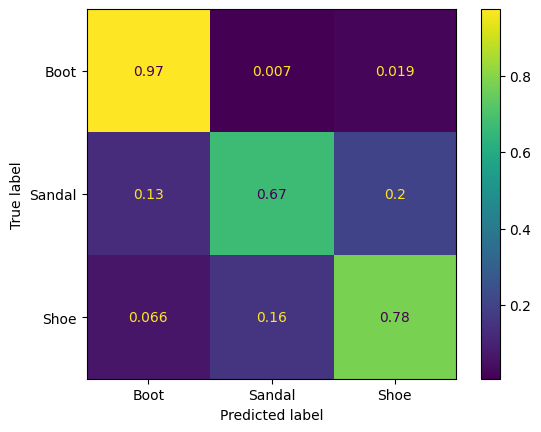

In [110]:
# plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(zero_true, resnet_pred, normalize='true')
plt.show()

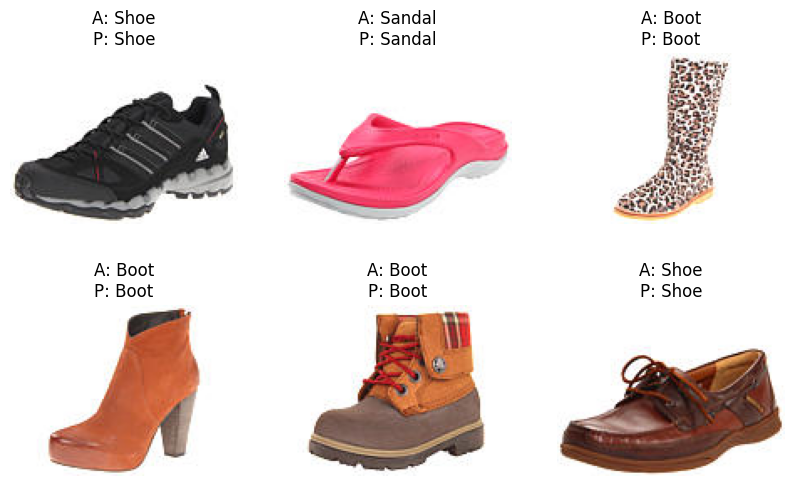

In [113]:
# plot the samples
plot_samples(datasets['test'].select(range(6)), labels, resnet_predictions)

In [114]:
# finish the experiment
run.finish()

eval/accuracy,▁▇██
eval/f1,▁▇██
eval/loss,█▃▁▁
eval/runtime,█▂▃▁
eval/samples_per_second,▁▆▄█
eval/steps_per_second,▁▆▄█
train/epoch,▁▁▅▅████
train/global_step,▁▁▅▅████
train/learning_rate,█▅▁
train/loss,█▄▁
train/total_flos,▁
